# Tutorial for simulated data
This tutorial offers a step-by-step guide for reproducing the simulation results described in our paper. For each simulated dataset, we created two modalities: one corresponding to the transcriptome and the other to the proteome. The datasets contain several ground truth patterns, with some shared across both modalities and others specific to only one. These simulated data are then used as input for our algorithm, which generates two different types of outputs depending on user selection.

# Domain Clustering on Simulated data

Building data and neighboring graphs...


Epoch Loss:279.149: 100%|██████████| 100/100 [00:40<00:00,  2.44it/s]

fitting ...
  |                                                                      |   0%

  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


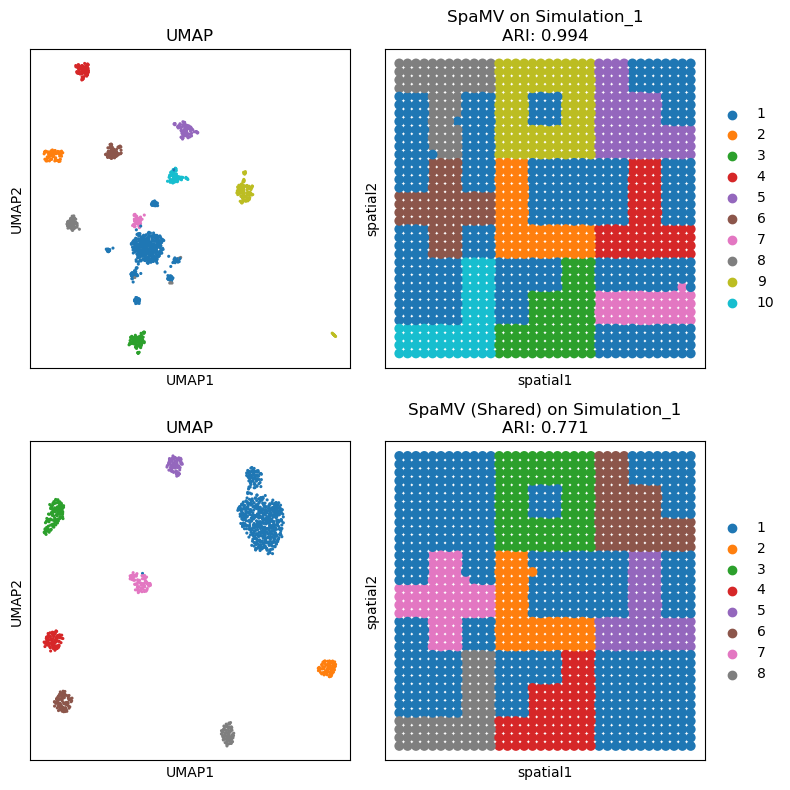

In [2]:
# SpaMV results
import anndata
from sklearn.metrics import adjusted_rand_score

from SpaMV.spamv import SpaMV
from SpaMV.utils import clr_normalize_each_cell, clustering
import scanpy as sc
import matplotlib.pyplot as plt

dataset = 'Simulation_1'

data_rna = sc.read_h5ad('Data/' + dataset + '/adata_RNA.h5ad')
data_pro = sc.read_h5ad('Data/' + dataset + '/adata_ADT.h5ad')
sc.pp.normalize_total(data_rna)
sc.pp.log1p(data_rna)
sc.pp.pca(data_rna)
data_rna = anndata.AnnData(data_rna.obsm['X_pca'], obs=data_rna.obs, obsm=data_rna.obsm)
data_pro = clr_normalize_each_cell(data_pro)
sc.pp.pca(data_pro)
data_pro = anndata.AnnData(data_pro.obsm['X_pca'], obs=data_pro.obs, obsm=data_pro.obsm)

model = SpaMV([data_rna, data_pro], interpretable=False, max_epochs_stage1=100)
model.train()

data_rna.obsm['SpaMV'] = model.get_embedding()
clustering(data_rna, n_clusters=10, key='SpaMV')

data_rna.obsm['SpaMV (Shared)'] = data_rna.obsm['SpaMV'][:, :model.zs_dim]
if dataset == 'Simulation_1':
    n_clusters = 8
elif dataset == 'Simulation_2':
    n_clusters = 6
elif dataset == 'Simulation_3':
    n_clusters = 4
else:
    n_clusters = 10
clustering(data_rna, n_clusters=n_clusters, key='SpaMV (Shared)', add_key='SpaMV (Shared)')
fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # 1 row, 2 columns

sc.pp.neighbors(data_rna, use_rep='SpaMV')
sc.tl.umap(data_rna)
sc.pl.umap(data_rna, color='SpaMV', ax=axes[0][0], show=False, legend_loc='none', s=20, title='UMAP')
sc.pl.embedding(data_rna, color='SpaMV', basis='spatial', s=200, show=False, title='SpaMV on {}\nARI: {:.3f}'.format(dataset, adjusted_rand_score(data_rna.obs['cluster'], data_rna.obs['SpaMV'])), ax=axes[0][1])
sc.pp.neighbors(data_rna, use_rep='SpaMV (Shared)')
sc.tl.umap(data_rna)
sc.pl.umap(data_rna, color='SpaMV (Shared)', ax=axes[1][0], show=False, legend_loc='none', s=20, title='UMAP')
sc.pl.embedding(data_rna, color='SpaMV (Shared)', basis='spatial', s=200, show=False, title='SpaMV (Shared) on {}\nARI: {:.3f}'.format(dataset, adjusted_rand_score(data_rna.obs['cluster'], data_rna.obs['SpaMV (Shared)'])), ax=axes[1][1])

plt.tight_layout()
plt.show()

# Interpretable Dimension Reduction on Simulated Data

Building data and neighboring graphs...


Epoch Loss:1910.869: 100%|██████████| 200/200 [01:53<00:00,  1.77it/s]


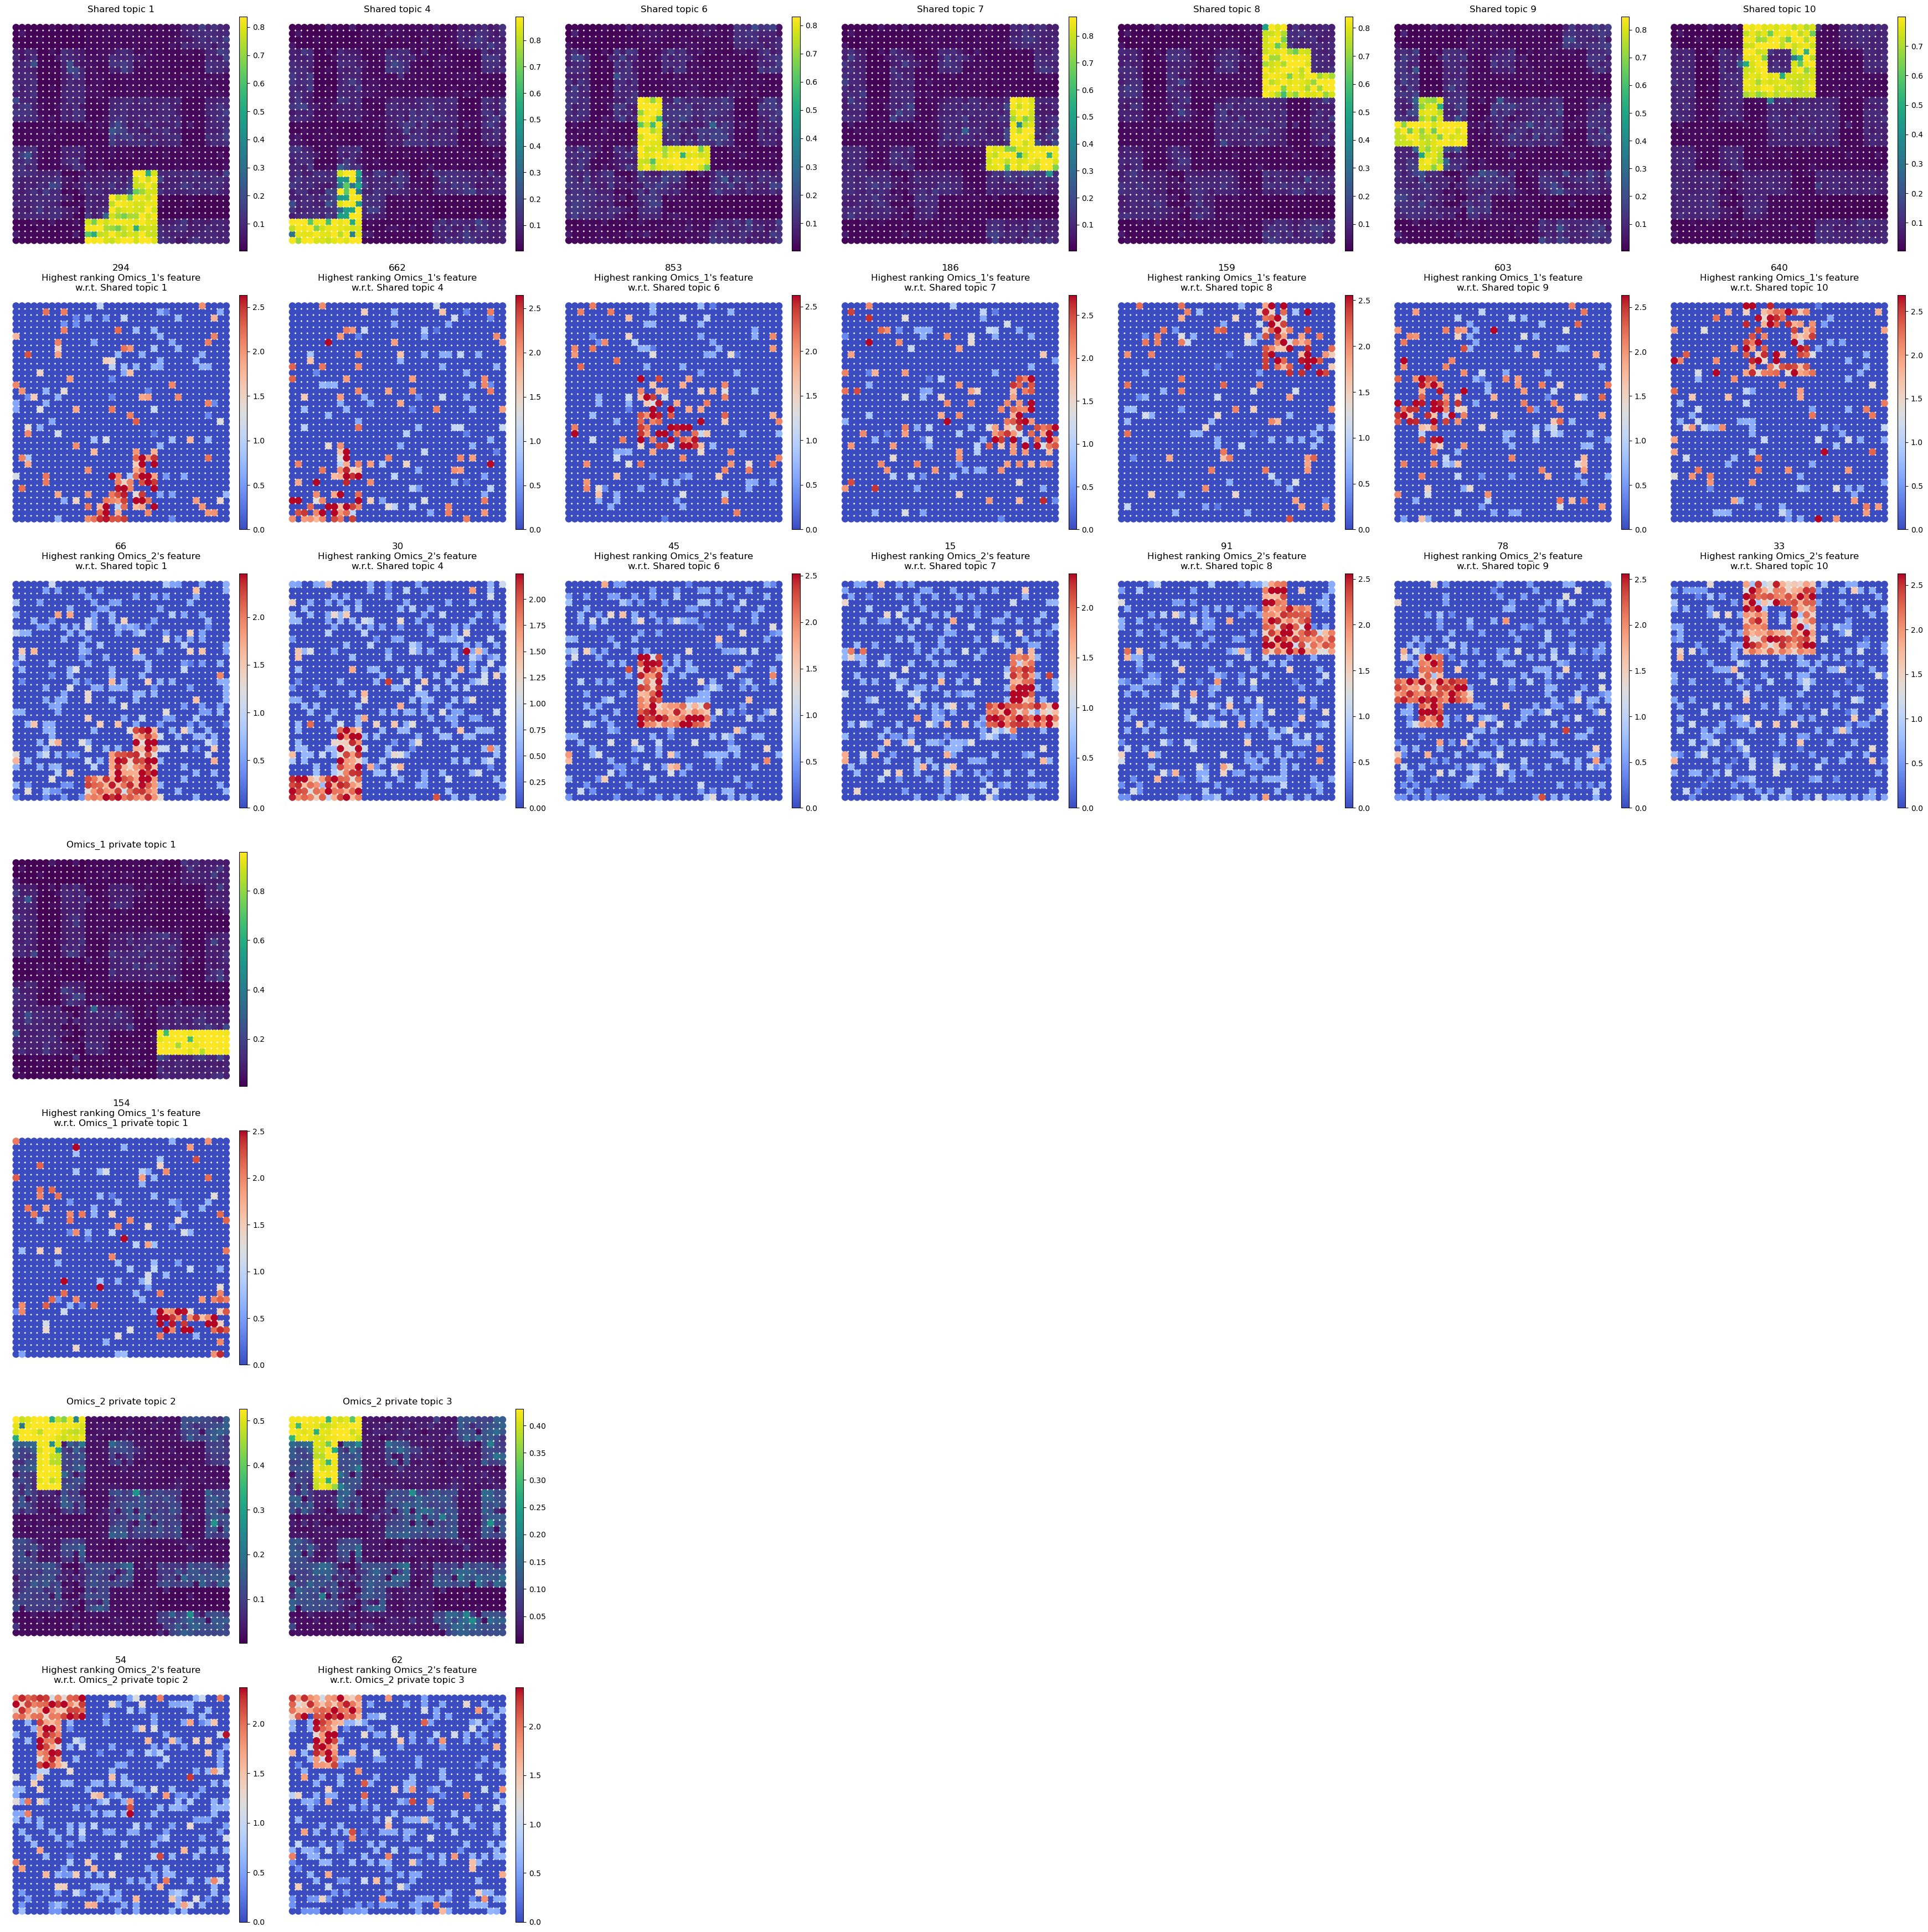

In [3]:
from SpaMV.spamv import SpaMV
from SpaMV.utils import clr_normalize_each_cell, plot_embedding_results
import scanpy as sc

dataset = 'Simulation_1'
data_rna = sc.read_h5ad('Data/' + dataset + '/adata_RNA.h5ad')
sc.pp.normalize_total(data_rna)
sc.pp.log1p(data_rna)
data_pro = sc.read_h5ad('Data/' + dataset + '/adata_ADT.h5ad')
data_pro = clr_normalize_each_cell(data_pro)
model = SpaMV([data_rna, data_pro], alphas=[3, 3], interpretable=True, neighborhood_embedding=5, threshold_background=5, max_epochs_stage1=400, max_epochs_stage2=200)
model.train()

z, w = model.get_embedding_and_feature_by_topic(threshold=.1)
plot_embedding_results([data_rna, data_pro], model.omics_names, z, w, save=False, show=True, size=350)